In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error

In [2]:
def body_to_nav(roll, pitch, yaw):
    cr = np.cos(roll)
    sr = np.sin(roll)
    cp = np.cos(pitch)
    sp = np.sin(pitch)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    dcm = np.array([[cp*cy, -cr*sy+sr*sp*cy, sr*sy+cr*sp*cy],
                    [cp*sy, cr*cy+sr*sp*sy, -sr*cy+cr*sp*sy],
                    [-sp, sr*cp, cr*cp]])
    
    return dcm

In [3]:
def quat_to_euler(quat):
    # Converts a quaternion matrix [w, x, y, z] into an Euler angle [roll, pitch, yaw] matrix
    euler = np.zeros(shape=(quat.shape[0], 3))
    for i in range(quat.shape[0]):
        qw, qx, qy, qz = quat[i, :]
        roll = np.arctan2(2*(qw*qx+qy*qz), 1-2*(qx**2+qy**2))
        pitch = -np.pi/2 + 2*np.arctan2(np.sqrt(1+2*(qw*qy-qx*qz)), np.sqrt(1-2*(qw*qy-qx*qz)))
        yaw = np.arctan2(2*(qw*qz+qx*qy), 1-2*(qy**2+qz**2))
        euler[i,:] = [roll, pitch, yaw]
    return euler

In [4]:
def process_trajectory(traj, data_params, train_mode=False):
    """Data import from file"""
    # GPS
    gps_pos = traj['gps']['position']
    # Ground truth
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    gnd_vel = traj['groundtruth']['velocity']
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    """Sample high frequency IMU data to the same frequency as GPS"""
    # Get average IMU data for each timestep of GPS data (IMU 100Hz, GPS 1Hz)
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    accel_data = np.zeros(shape=(imu_sumdiv+1,3))
    accel_data[0,:] = imu_acc[0,:]
    gyro_data = np.zeros(shape=(imu_sumdiv+1,3))
    gyro_data[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        accel_data[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        gyro_data[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)
    
    """Sample attitude or integrate gyros"""
    if data_params["TRUE_ATT"]:
        # Get average attitude data for each timestep of GPS data (attitude 100Hz, GPS 1Hz)
        gnd_sumdiv = int(np.floor(gnd_att.shape[0]/100))
        attitude_data = np.zeros(shape=(gnd_sumdiv+1,3))
        attitude_data[0,:] = gnd_att[0,:]
        for i in range(gnd_sumdiv):
            attitude_data[i+1,:] = np.average(gnd_att[1+100*i:1+100*(i+1),:], axis=0)
    else:
        gyro_integration = np.zeros_like(gyro_data)
        gyro_integration[0,:] = gnd_att[0,:]
        for i in range(1, gyro_integration.shape[0]):
            gyro_integration[i,:] = gyro_integration[i-1,:] + gyro_data[i,:]
        attitude_data = gyro_integration

    """Transfor accelerometer from body to nav"""
    if data_params["ACCEL_TO_NAV"]:
        for i in range(accel_data.shape[0]):
            roll, pitch, yaw = attitude_data[i,:]
            accel_data[i,:] = body_to_nav(roll=roll, pitch=pitch, yaw=yaw) @ accel_data[i,:]
        accel_data = accel_data - [0, 0, -9.81]
    
    """Sample velocity or integrate accelerometers"""
    if data_params["TRUE_VEL"]:
        # Get average velocity data for each timestep of GPS data (attitude 100Hz, GPS 1Hz)
        gnd_sumdiv = int(np.floor(gnd_vel.shape[0]/100))
        velocity_data = np.zeros(shape=(gnd_sumdiv+1,3))
        velocity_data[0,:] = gnd_vel[0,:]
        for i in range(gnd_sumdiv):
            velocity_data[i+1,:] = np.average(gnd_vel[1+100*i:1+100*(i+1),:], axis=0)
    else:
        accel_integration = np.zeros_like(accel_data)
        accel_integration[0,:] = gnd_vel[0,:]
        for i in range(1, accel_integration.shape[0]):
            accel_integration[i,:] = accel_integration[i-1,:] + accel_data[i,:]
        velocity_data = accel_integration

    """Form GPS delta data"""
    # Change in GPS position
    gps_delta = gps_pos[1:,:] - gps_pos[:-1,:]
    gps_delta = np.vstack((np.zeros(shape=(1,3)), gps_delta))

    """Normalize input data"""
    if data_params["NORMALIZE_INPUT"]:
        if train_mode:
            # Accel
            acc_mean = np.mean(accel_data, axis=0)
            data_params["acc_mean"] = acc_mean
            acc_std  = np.std(accel_data, axis=0)
            data_params["acc_std"] = acc_std
            # Gyro
            gyr_mean = np.mean(gyro_data, axis=0)
            data_params["gyr_mean"] = gyr_mean
            gyr_std  = np.std(gyro_data, axis=0)
            data_params["gyr_std"] = gyr_std
            # Attitude
            att_mean = np.mean(attitude_data, axis=0)
            data_params["att_mean"] = att_mean
            att_std  = np.std(attitude_data, axis=0)
            data_params["att_std"] = att_std
            # Velocity
            vel_mean = np.mean(velocity_data, axis=0)
            data_params["vel_mean"] = vel_mean
            vel_std  = np.std(velocity_data, axis=0)
            data_params["vel_std"] = vel_std

            accel_data = (accel_data - acc_mean)/acc_std
            gyro_data = (gyro_data - gyr_mean)/gyr_std
            attitude_data = (attitude_data - att_mean)/att_std
            velocity_data = (velocity_data - vel_mean)/vel_std
        else:
            accel_data = (accel_data - data_params["acc_mean"])/data_params["acc_std"]
            gyro_data = (gyro_data - data_params["gyr_mean"])/data_params["gyr_std"]
            attitude_data = (attitude_data - data_params["att_mean"])/data_params["att_std"]
            velocity_data = (velocity_data - data_params["vel_mean"])/data_params["vel_std"]
    
    """Normalize output data"""
    if data_params["NORMALIZE_OUTPUT"]:
        if train_mode:
            gps_mean = np.mean(gps_delta, axis=0)
            data_params["gps_mean"] = gps_mean
            gps_std  = np.std(gps_delta, axis=0)
            data_params["gps_std"] = gps_std

            gps_delta = (gps_delta - gps_mean)/gps_std
        else:
            gps_delta = (gps_delta - data_params["gps_mean"])/data_params["gps_std"]

    return gps_delta, accel_data, gyro_data, attitude_data, velocity_data

In [5]:
def test_model(traj, model, data_params):
    gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=False)

    dp_ = gps_delta.shape[0]
    Y_pred_ = np.zeros(shape=(dp_,3))
    for i in range(dp_):
        if i <= data_params["MODEL_DELAY"]:
            # STILL NEED MORE DATA
            Y_pred_[i,:] = gps_delta[i,:]
        else:
            # ENOUGH DATA
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [accel_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [gyro_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [attitude_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_VELO"]:
                X_ = np.hstack((X_, [velocity_data[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [Y_pred_[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            Y_ = model(X_)
            Y_pred_[i,:] = Y_
    return Y_pred_, gps_delta

In [22]:
f = h5py.File('data/drone_sim/sunny.hdf5')
train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
             '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

data_params = {"MODEL_DELAY": 2, 
               "NORMALIZE_INPUT": 1, 
               "NORMALIZE_OUTPUT": 1, 
               "INPUT_ACCL": 1, 
               "INPUT_GYRO": 1, 
               "INPUT_ATTI": 1, 
               "INPUT_VELO": 1,
               "INPUT_POUT": 1,
               "TRUE_ATT": 1,
               "TRUE_VEL": 1,
               "ACCEL_TO_NAV": 1
}

"""Autoregressive exogeneous model trainset creation"""
# Construct training data set
Y_train = np.zeros(shape=(0,3))
features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
X_train = np.zeros(shape=(0,features))
for i, traj_num in enumerate(train_set):
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
    # Construct training set
    model_delay = data_params["MODEL_DELAY"]
    dp_ = gps_delta.shape[0]-model_delay
    Y_train_ = np.zeros(shape=(dp_, 3))
    X_train_ = np.zeros(shape=(dp_, features))
    for i in range(dp_):
        Y_ = gps_delta[i+model_delay,:]
        Y_train_[i,:] = Y_
        X_ = np.zeros(shape=(1,0))
        if data_params["INPUT_ACCL"]:
            X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_GYRO"]:
            X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_ATTI"]:
            X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_VELO"]:
            X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_POUT"]:
            X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
        X_train_[i,:] = X_
    
    # Add to X and Y sets
    X_train = np.vstack((X_train, X_train_))
    Y_train = np.vstack((Y_train, Y_train_))


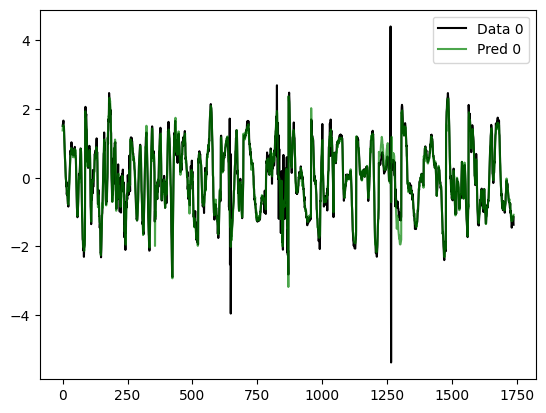

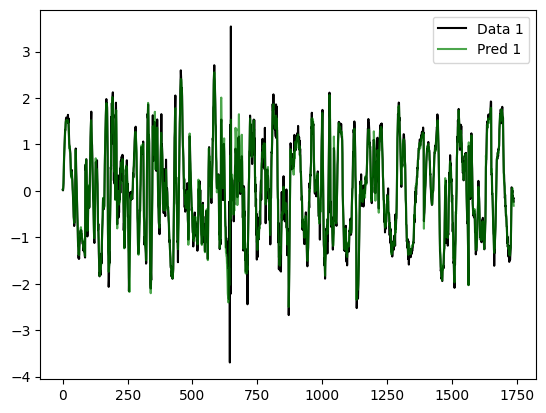

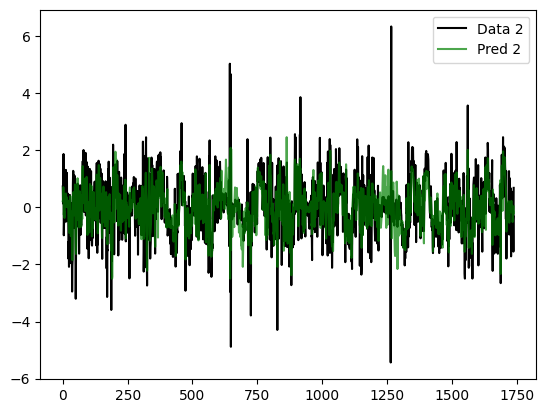

In [23]:
"""Least-squares fitting"""
# Train LS model
BETA_REG = 1e-1
dp_, features_ = X_train.shape
_, outputs_ = Y_train.shape
w_ls = np.zeros(shape=(outputs_, features_, 1))
Y_train_ls = np.zeros(shape=(dp_, outputs_))
for i in range(outputs_):
    w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
    Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()

def model_ls(x):
    outputs_, _, _ = w_ls.shape
    dp_, _ = x.shape
    y_ = np.zeros(shape=(dp_, outputs_))
    for i in range(outputs_):
        y_[:,i] = (x @ w_ls[i,:,:]).flatten()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_ls[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

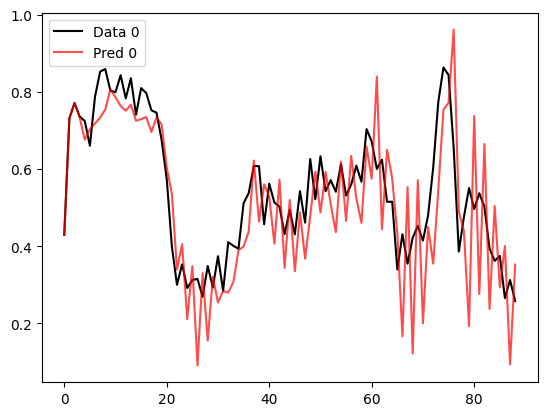

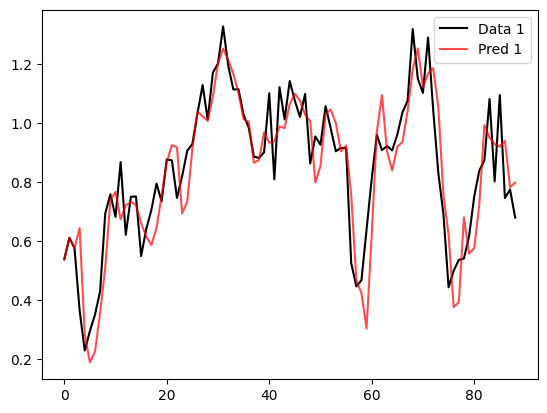

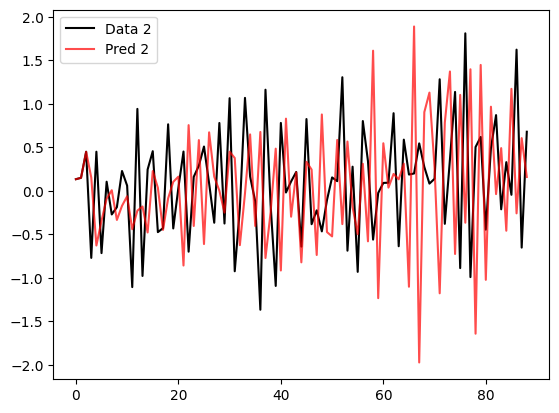

In [24]:
"""Least squares testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0027"]
Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_ls[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

Epoch 1, training loss: 1.0304
Epoch 100, training loss: 0.1579
Epoch 200, training loss: 0.1294
Epoch 300, training loss: 0.1026
Epoch 400, training loss: 0.0515
Epoch 500, training loss: 0.0362
Epoch 600, training loss: 0.0253
Epoch 700, training loss: 0.0229
Epoch 800, training loss: 0.0150
Epoch 900, training loss: 0.0095
Epoch 1000, training loss: 0.0107
Epoch 1100, training loss: 0.0132
Epoch 1200, training loss: 0.0088
Epoch 1300, training loss: 0.0059
Epoch 1400, training loss: 0.0047
Epoch 1500, training loss: 0.0071
Epoch 1600, training loss: 0.0039
Epoch 1700, training loss: 0.0035
Epoch 1800, training loss: 0.0037
Epoch 1900, training loss: 0.0055
Epoch 2000, training loss: 0.0027
Epoch 2100, training loss: 0.0024
Epoch 2200, training loss: 0.0046
Epoch 2300, training loss: 0.0064
Epoch 2400, training loss: 0.0023
Epoch 2500, training loss: 0.0032
Epoch 2600, training loss: 0.0018
Epoch 2700, training loss: 0.0015
Epoch 2800, training loss: 0.0015
Epoch 2900, training loss:

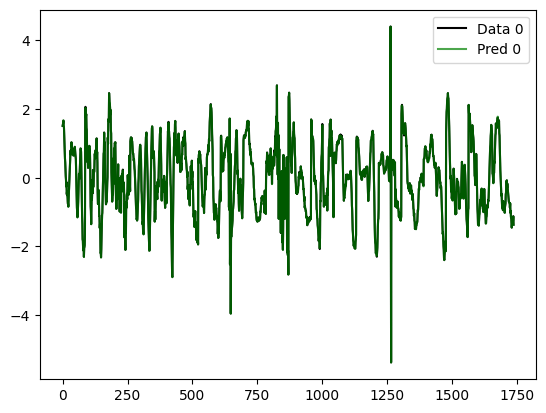

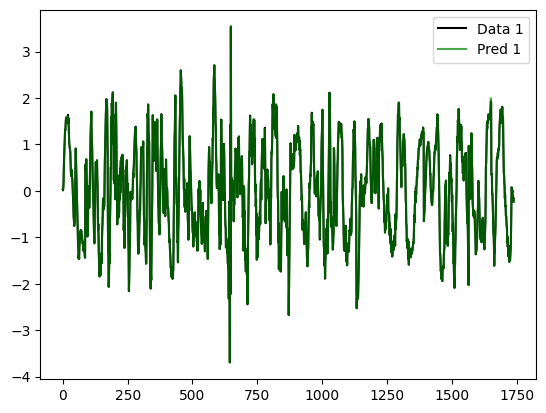

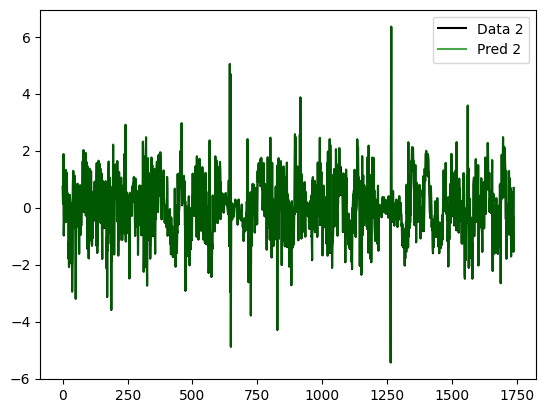

In [25]:
"""Neural network training"""
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)

dp, features = X_train_tensor.shape
_, outputs = Y_train_tensor.shape

NUM_HIDDEN_LAYERS = 128
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
WEIGHT_DECAY = 0
NUM_EPOCHS = 10000

# Define model, loss function, and search algorithm
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=8),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=8, out_features=outputs)
)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Train model
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    Y_pred_ = model(X_train_tensor)
    loss_value = loss(Y_pred_, Y_train_tensor)

    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or ((epoch % 100) == 0):
        print(f"Epoch {epoch}, training loss: {loss_value.item():.4f}")

# Evaluate train set
model.eval()
with torch.no_grad():
    Y_train_nn = model(X_train_tensor).numpy()

def model_nn(x):
    x_tensor = torch.from_numpy(x).to(torch.float32)
    model.eval()
    with torch.no_grad():
        y_ = model(x_tensor).numpy()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_nn[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

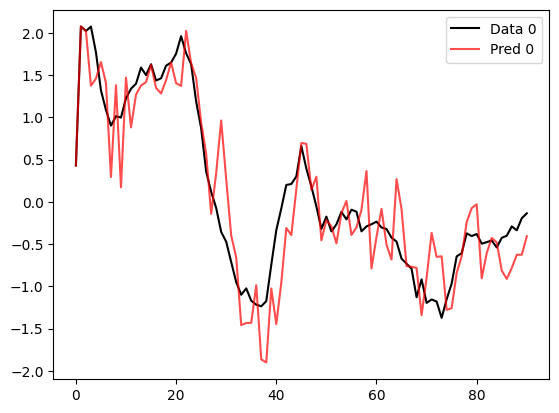

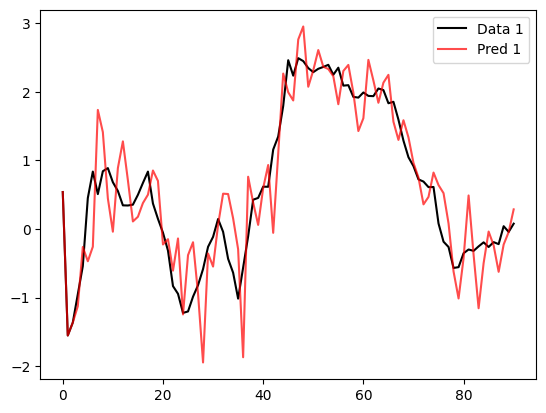

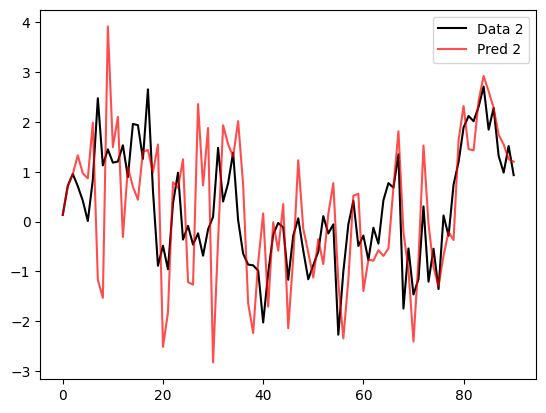

In [26]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0024"]
Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_nn[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

In [38]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
mse_ls_avg = np.zeros(shape=(3,))
mse_nn_avg = np.zeros(shape=(3,))
for traj_num in test_set:
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)
    Y_test_ls, _ = test_model(traj=traj, model=model_ls, data_params=data_params)
    
    mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
    mse_nn = mean_squared_error(Y_test, Y_test_nn, multioutput="raw_values")
    
    mse_ls_avg = mse_ls_avg + mse_ls
    mse_nn_avg = mse_nn_avg + mse_nn

    print(f"\nTraj_{traj_num}")
    print(f"LS: x:{mean_squared_error(Y_test[:,0], Y_test_ls[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}")
    print(f"NN: x:{mean_squared_error(Y_test[:,0], Y_test_nn[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}")
mse_ls_avg = mse_ls_avg/len(test_set)
mse_nn_avg = mse_nn_avg/len(test_set)

print(f"NN: {mse_nn_avg}")
print(f"LS: {mse_ls_avg}")


Traj_0020
LS: x:0.6682 y:2.2541, z:2.2541
NN: x:1.3992 y:3.5251, z:3.5251

Traj_0021
LS: x:2.0612 y:2.5040, z:2.5040
NN: x:5.5372 y:1.9440, z:1.9440

Traj_0022
LS: x:0.2612 y:0.7506, z:0.7506
NN: x:4.8097 y:1.1239, z:1.1239

Traj_0023
LS: x:0.8607 y:1.5359, z:1.5359
NN: x:2.6836 y:3.5782, z:3.5782

Traj_0024
LS: x:0.3476 y:2.7033, z:2.7033
NN: x:4.4951 y:4.4174, z:4.4174

Traj_0025
LS: x:1.2846 y:0.4007, z:0.4007
NN: x:4.9413 y:0.5263, z:0.5263

Traj_0026
LS: x:0.5946 y:0.5431, z:0.5431
NN: x:3.0576 y:0.3267, z:0.3267

Traj_0027
LS: x:0.3275 y:0.9857, z:0.9857
NN: x:2.6400 y:1.3138, z:1.3138

Traj_0028
LS: x:0.5918 y:1.0223, z:1.0223
NN: x:2.5011 y:0.4869, z:0.4869

Traj_0029
LS: x:0.8788 y:0.7426, z:0.7426
NN: x:5.3362 y:1.1006, z:1.1006
NN: [ 3.74009829  1.83428821 19.42138393]
LS: [0.7876271  1.34421689 0.9927943 ]
